# 1. Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/datasets/faces/labels.csv')



In [2]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [3]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Text(0.5, 1.0, 'Age distribution')

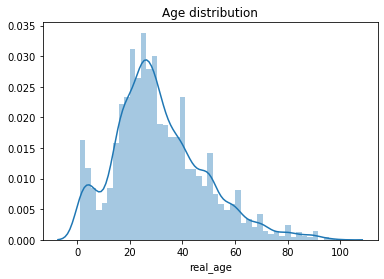

In [4]:
sns.distplot(data['real_age']).set_title('Age distribution')

In [5]:
def open_image(entry):
    image = Image.open('/datasets/faces/final_files/'+ entry['file_name']) 
    image_array = np.array(image) 
    plt.imshow(image_array)
    plt.title('AGE is '+ str(entry['real_age']))
    plt.show()

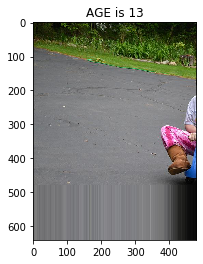

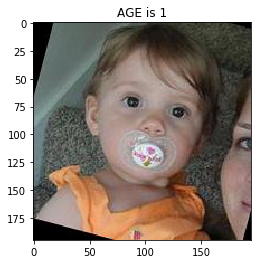

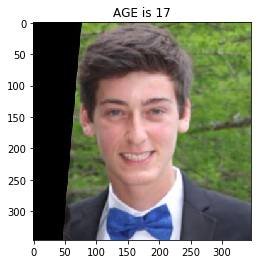

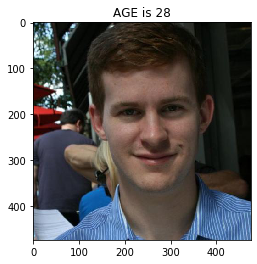

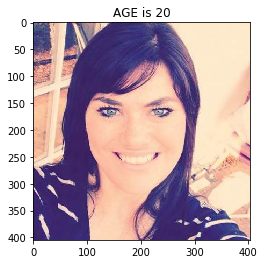

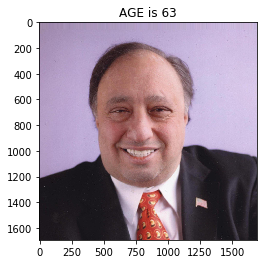

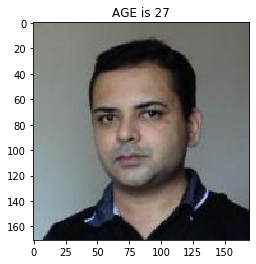

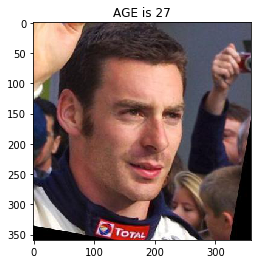

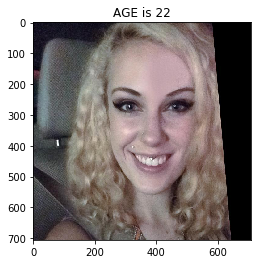

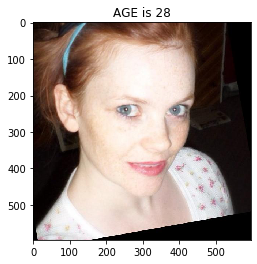

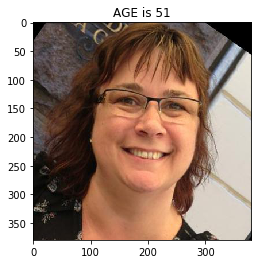

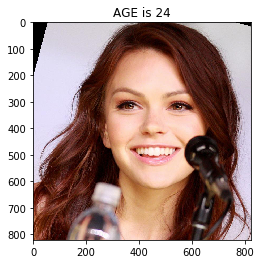

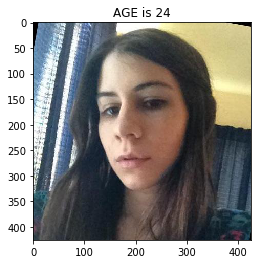

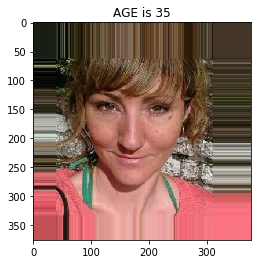

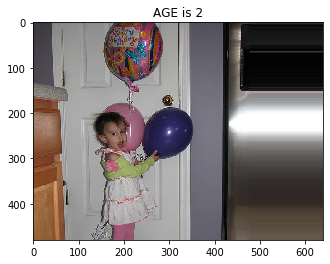

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
dtype: object

In [6]:
subsample = data.sample(n=15).reset_index()
subsample.apply(open_image,axis=1)

#### Conclusions:
* There are aout 7600 images.
* Ages distribution is normal - distributed around age of ~30.
* Age data is in-balanced which can effect the model and cause over-fitting around ages 20-40.
* Not all images are face-images, which can cause difficult in the age recognition.
* Not all imaged are at the same size ratio.
* One of the pictures doesnt include face at all, hope this is not common

# 2. Model training

Transfer the model training code and the result of printing on the screen here.


(The code in this section is run on a separate GPU platform, so it is not designed as a cell with a code, but as a code in a text cell)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

def load_train(path):
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.,validation_split=0.25)
    
    directory =  path + 'final_files/'
    df = pd.read_csv(path + 'labels.csv')
    
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory =  directory ,
        x_col="file_name",
        y_col="real_age",
        subset="training",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode='raw')
    
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    df = pd.read_csv(path + 'labels.csv')
    directory =  path + 'final_files/'
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=directory,
        x_col="file_name",
        y_col="real_age",
        subset="validation",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode='raw')
    
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights= 'imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/20
2020-09-07 11:37:08.204455: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-09-07 11:37:08.526480: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 52s - loss: 217.8102 - mae: 10.9761 - val_loss: 440.9400 - val_mae: 15.8452
Epoch 2/20
178/178 - 43s - loss: 124.8521 - mae: 8.4543 - val_loss: 390.7920 - val_mae: 14.7729
Epoch 3/20
178/178 - 43s - loss: 106.8359 - mae: 7.8385 - val_loss: 345.1879 - val_mae: 13.8583
Epoch 4/20
178/178 - 44s - loss: 90.3477 - mae: 7.2224 - val_loss: 261.9613 - val_mae: 12.0535
Epoch 5/20
178/178 - 43s - loss: 78.6284 - mae: 6.7553 - val_loss: 120.2689 - val_mae: 8.3186
Epoch 6/20
178/178 - 44s - loss: 65.0460 - mae: 6.1976 - val_loss: 152.9230 - val_mae: 8.7163
Epoch 7/20
178/178 - 43s - loss: 58.9453 - mae: 5.8693 - val_loss: 101.0950 - val_mae: 7.7956
Epoch 8/20
178/178 - 43s - loss: 59.3315 - mae: 5.8693 - val_loss: 104.4309 - val_mae: 7.7146
Epoch 9/20
178/178 - 43s - loss: 48.8732 - mae: 5.3463 - val_loss: 103.5266 - val_mae: 7.6793
Epoch 10/20
178/178 - 43s - loss: 44.4982 - mae: 5.1150 - val_loss: 119.5619 - val_mae: 7.9763
Epoch 11/20
178/178 - 43s - loss: 44.0334 - mae: 5.0649 - val_loss: 90.6463 - val_mae: 7.3399
Epoch 12/20
178/178 - 43s - loss: 37.8870 - mae: 4.7204 - val_loss: 106.6457 - val_mae: 7.8832
Epoch 13/20
178/178 - 44s - loss: 36.4009 - mae: 4.6123 - val_loss: 94.3262 - val_mae: 7.5008
Epoch 14/20
178/178 - 43s - loss: 35.2854 - mae: 4.5604 - val_loss: 98.2852 - val_mae: 7.6506
Epoch 15/20
178/178 - 43s - loss: 30.4263 - mae: 4.2295 - val_loss: 96.6216 - val_mae: 7.3061
Epoch 16/20
178/178 - 43s - loss: 25.7867 - mae: 3.9341 - val_loss: 95.2502 - val_mae: 7.3085
Epoch 17/20
178/178 - 44s - loss: 23.7289 - mae: 3.7670 - val_loss: 104.3226 - val_mae: 7.6809
Epoch 18/20
178/178 - 43s - loss: 22.5822 - mae: 3.6307 - val_loss: 76.5140 - val_mae: 6.4536
Epoch 19/20
178/178 - 43s - loss: 20.4514 - mae: 3.4681 - val_loss: 86.0976 - val_mae: 7.0613
Epoch 20/20
178/178 - 44s - loss: 18.8584 - mae: 3.3363 - val_loss: 76.2427 - val_mae: 6.5824
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 76.2427 - mae: 6.5824
Test MAE: 6.5824

```

# 3. Trained model analysis

* Data distribution was examined and a sample of imageswas printed for EDA.
* Data splitting was done with image_data_generator with 1/4 of data used for training.
* Used ResNet50 pre-trained model w/o upper layer.
* on top pf ResNet50 lower layer I used 1 Global-average-pooling-2d layer + 1 dense layer with 'RELU' as activation function.
* Used 'Adam' optimizer with learning-rate of 0.0003 and MSE as loss function.


# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis have been transferred to the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model's printing on the screen result has been transferred to the final notebook
- [x]  The findings have been provided based on the results of the model training